https://neo4j.com/graphacademy/online-training/data-science/part-2/

/media/lnr-ai/applications/./neo4j-desktop-offline-1.2.7-x86_64.AppImage 

In [1]:
import pandas as pd
from py2neo import Graph
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
# graph = Graph()

In [2]:
import matplotlib 
import matplotlib.pyplot as plt

### Part 1, EDA

https://colab.research.google.com/github/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/02_EDA.ipynb#scrollTo=0r69d4ek5huR

#### Is the Neo4J db up and running?

In [3]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [(_-2:Merchant {constraints: ['CONSTRAINT ON ( merchant:Merchant ) ASSERT (merchant.franchisename) IS UNIQUE'], indexes: [], name: 'Merchant'}),
   (_-1:Client {constraints: ['CONSTRAINT ON ( client:Client ) ASSERT (client.dedupestatic) IS UNIQUE'], indexes: [], name: 'Client'}),
   (_-3:Segment {constraints: ['CONSTRAINT ON ( segment:Segment ) ASSERT (segment.seg_l3_num) IS UNIQUE'], indexes: [], name: 'Segment'})],
  'relationships': [(Client)-[:TRANSACTED_AT {}]->(Merchant),
   (Merchant)-[:MERCHANT_VALUE_LINK {}]->(Merchant),
   (Merchant)-[:MERCHANT_LINK {}]->(Merchant),
   (Merchant)-[:MERCHANT_FEET_LINK {}]->(Merchant)]}]

#### In the browser, execute the following command:
MATCH (c:Client)-[transacted_at:TRANSACTED_AT]->(merchant:Merchant) RETURN c,transacted_at,merchant LIMIT 50

#### Drill down into the Nedbank Behaviour db. How many nodes do we have for each label?

In [4]:
# https://neo4j.com/graphacademy/online-training/data-science/part-2/
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Segment,35
1,Merchant,91942
0,Client,2216269


#### Visualize counts:

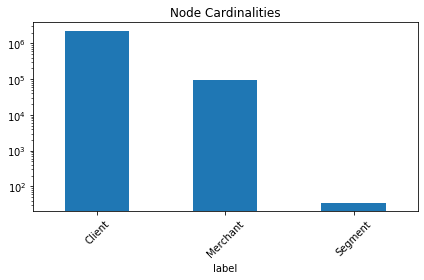

In [5]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Reveal the client node and its properties:

In [6]:
exploratory_client_query="""MATCH (c:Client)
RETURN labels(c), keys(c) as properties, size(keys(c)), count(*)
ORDER BY size(keys(c)) DESC"""
df=graph.run(exploratory_client_query).to_data_frame()
df.iloc[0]['properties']

['seg_l3_num',
 'period',
 'seg_l3_str',
 'totaltransactionamount',
 'dedupestatic',
 'totaltransactioncount']

In [7]:
exploratory_client_query="""MATCH (m:Merchant)
RETURN labels(m), keys(m) as properties, size(keys(m)), count(*)
ORDER BY size(keys(m)) DESC"""
df=graph.run(exploratory_client_query).to_data_frame()
df.iloc[0]['properties']

['franchisename',
 'discretionary',
 'companyname',
 'group_id',
 'division_id',
 'subclass_id',
 'class_id',
 'companyindex',
 'totaltransactioncount',
 'period',
 'totaltransactionamount']

#### Here are the types of relationships and their counts in the db:

In [8]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
1,MERCHANT_LINK,127047
2,MERCHANT_FEET_LINK,141704
3,MERCHANT_VALUE_LINK,245568
0,TRANSACTED_AT,9914389


#### Visualize relationship cardinalities:

In [ ]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Explore client nodes:

Lets look at the relationship COUNTS between client and Merchant:

In [9]:
exploratory_client_query = """
MATCH (client:Client)-[transacted_at:TRANSACTED_AT]->(merchant:Merchant)
WITH client.dedupestatic as client, count(transacted_at) as number_merchant_relationships
RETURN client, number_merchant_relationships
ORDER BY number_merchant_relationships
"""
df=graph.run(exploratory_client_query).to_data_frame()
df.tail()

,client,number_merchant_relationships
1908907,9.10300001710005e+19,1516
1908908,9.10500001710006e+19,1873
1908909,9.10400001710005e+19,1946
1908910,9.10400001710006e+19,2046
1908911,9.10600001710006e+19,2065


In [12]:
df.head(10)

,client,number_merchant_relationships
0,2.11697718705e+11,1
1,1.91574857e+11,1
2,1.81001500371e+11,1
3,2.11079047203e+11,1
4,1.90000572934e+11,1
5,2.11577951834e+11,1
6,1.10064549402e+11,1
7,2.11619066605e+11,1
8,1.20000213358e+11,1
9,1.91718558234e+11,1


In [10]:
int(float(list(df['client'])[-1]))

91060000171000594432

In [11]:
dedupestatic=list(df['client'])[-1]
a_client_query = """
MATCH (client:Client {dedupestatic:$dedupestatic})-[:TRANSACTED_AT]->(merchant:Merchant)
WITH client.dedupestatic as client, merchant.franchisename as franchisename, merchant.companyname as companyname
RETURN client, franchisename,companyname
"""
graph.run(a_client_query, {"dedupestatic": dedupestatic}).to_data_frame()

,client,franchisename,companyname
0,9.10600001710006e+19,MEDIRITE KIMBERLEY,MEDIRITE
1,9.10600001710006e+19,CLICKS HEIDELBERG,CLICKS
2,9.10600001710006e+19,MEDIRITE - BARTLETT,MEDIRITE
3,9.10600001710006e+19,WOOLWORTHS NORWOOD,WOOLWORTHS
4,9.10600001710006e+19,PNP POLOKWANE,PNP
...,...,...,...
2060,9.10600001710006e+19,PNP UMHLANGA,PNP
2061,9.10600001710006e+19,SUPERSPAR GATEWAY HERMANU,SPAR
2062,9.10600001710006e+19,PEP VEREENIGING,PEP
2063,9.10600001710006e+19,SHOPRITE GRAAFF REINET,SHOPRITE


#### Now let's explore the Merchant data. 

This looks at the COMPANY level first and counts the unique relationships:

In [13]:
exploratory_company_query = """
MATCH (client:Client)-[transacted_at:TRANSACTED_AT]->(merchant:Merchant)
WHERE merchant.companyname<>'Unknown'
WITH merchant.companyname as company, count(transacted_at) as number_company_relationships
RETURN company, number_company_relationships
ORDER BY number_company_relationships DESC
"""
df=graph.run(exploratory_company_query).to_data_frame()
df.head()

,company,number_company_relationships
0,SPAR,1112968
1,PNP,1011818
2,SHOPRITE,647844
3,CHECKERS,595026
4,WOOLWORTHS,521081


This looks at the MERCHANT level and counts the unique relationships:

In [14]:
exploratory_franchise_query = """
MATCH ()-[transacted_at:TRANSACTED_AT]->(merchant:Merchant)
WHERE merchant.companyname<>'Unknown'
WITH merchant.franchisename as merchant, count(transacted_at) as number_merchant_relationships
RETURN merchant, number_merchant_relationships
ORDER BY number_merchant_relationships DESC
"""
df=graph.run(exploratory_franchise_query).to_data_frame()
df.head()

,merchant,number_merchant_relationships
0,BOXER SUPERSTO,93970
1,NETFLIX.COM,84771
2,CheckersHyper,70692
3,payD Vodacom E,63589
4,Truworths,61202


Now let's explore the transaction data in more detail.  We need to zoom in on one Merchant. The following query finds Dischem and Dischem Dainfern Square in particular, the unique clients that visited this merchant, the number of unique Nedbank Clients that visited the Merchant (Merchant1) and then any other Merchant (Merchant2) these client may have visited and how many unique clients (merchant2_transactions) transacted at Merchant 2:

In [15]:
exploratory_query = """
MATCH (merchant1:Merchant {franchisename:'DIS-CHEM DAINFERN'})<-[t1:TRANSACTED_AT]-(client:Client)-[t2:TRANSACTED_AT]->(merchant2:Merchant)
WHERE ID(merchant1)<>ID(merchant2)
RETURN merchant1.franchisename AS merchant1, client.dedupestatic AS dedupestatic,  
merchant2.franchisename AS merchant2,t1.transactioncount as transactioncount1,
       size((merchant1)-[:TRANSACTED_AT]-()) AS merchant1_transactions, 
       t2.transactioncount as transactioncount2,
       size((merchant2)-[:TRANSACTED_AT]-()) AS merchant2_transactions
ORDER BY transactioncount1 DESC
"""

graph.run(exploratory_query).to_data_frame() 

,merchant1,dedupestatic,merchant2,transactioncount1,merchant1_transactions,transactioncount2,merchant2_transactions
0,DIS-CHEM DAINFERN,1.10078235707e+11,Dischem Dain,9,252,1,296
1,DIS-CHEM DAINFERN,1.10078235707e+11,Clicks Lonehill,9,252,1,324
2,DIS-CHEM DAINFERN,1.10078235707e+11,WOOLWORTHS LONEHILL,9,252,1,702
3,DIS-CHEM DAINFERN,1.10078235707e+11,Cltx Witkoppen Motors,9,252,1,107
4,DIS-CHEM DAINFERN,1.10078235707e+11,DIS-CHEM MORNINGSIDE,9,252,2,157
...,...,...,...,...,...,...,...
3264,DIS-CHEM DAINFERN,1.10027771407e+11,OCEAN BASKET,1,252,1,4130
3265,DIS-CHEM DAINFERN,1.10027771407e+11,SASOL FERNGATE,1,252,4,482
3266,DIS-CHEM DAINFERN,1.10027771407e+11,ENGEN BLOCK HOUSE-SO,1,252,1,128
3267,DIS-CHEM DAINFERN,1.10027771407e+11,WOOLWORTHS MAROUN SQ,1,252,6,277


In [16]:
exploratory_query = """
MATCH (merchant1:Merchant {franchisename:'DIS-CHEM DAINFERN'})<-[t1:TRANSACTED_AT]-(client:Client)-[t2:TRANSACTED_AT]->(merchant2:Merchant)
WHERE ID(merchant1)<>ID(merchant2)
RETURN merchant1.franchisename AS merchant1,  
merchant2.franchisename AS merchant2,
sum(t1.transactioncount) as transactioncounts1,
count(t1) AS merchant1_transactions,
sum(t2.transactioncount) as transactioncounts2,
count(t2) AS merchant2_transactions
ORDER BY transactioncounts1 DESC
"""

graph.run(exploratory_query).to_data_frame() 

,merchant1,merchant2,transactioncounts1,merchant1_transactions,transactioncounts2,merchant2_transactions
0,DIS-CHEM DAINFERN,PNP CRP DEINFERN SQUAR,232,116,252,116
1,DIS-CHEM DAINFERN,WOOLWORTHS MAROUN SQ,197,111,314,111
2,DIS-CHEM DAINFERN,Spar Broadacres Spar,137,72,185,72
3,DIS-CHEM DAINFERN,Clicks Dairnfern,118,62,96,62
4,DIS-CHEM DAINFERN,NETFLIX.COM,75,50,52,50
...,...,...,...,...,...,...
1218,DIS-CHEM DAINFERN,Makro Woodme,1,1,1,1
1219,DIS-CHEM DAINFERN,PNP CRP KYALAM,1,1,1,1
1220,DIS-CHEM DAINFERN,TOTAL SUMMIT R,1,1,3,1
1221,DIS-CHEM DAINFERN,PNP CRP KYALAMI,1,1,1,1


How many distinct co merchants does Dischem Daifern have?

In [ ]:
print('The clients of Dischem Dainfern transacted at',len(list(set(df.merchant2))), 'other merchants')